In [154]:
import os
import math
import random #to set the seed to replicate results
from datetime import datetime,timedelta #for today's date
from dateutil.relativedelta import relativedelta
import sys
import requests

from targets_plot_generator.src import generate_plot

import psycopg2
import psycopg2.extras
from psycopg2.extensions import AsIs

import pandas as pd 
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress #for the slope and the value of Y at X=0 of the linear trend line
from scipy.optimize import curve_fit
import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM,Conv1D,MaxPooling1D,Flatten,TimeDistributed #the two main layers of the model
from tensorflow.keras.optimizers import Adam, AdamW#for the training of the model
from tensorflow.keras.models import load_model

random.seed(42)  #set the seed to replicate results

pd.options.display.max_columns = None

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Preprocess Config

In [155]:
'''This is the timestep which indicates the window size'''
model_case_version_time_steps= '10'
'''This is the number of periods defined in the target(MPNxP) where x is the number of periods'''
model_case_version_main_target_code='5'

#today = '20220706'
today = datetime.today().strftime('%Y%m%d') #just for names of files (for now)
print('Today is', today)

''' Here, we define the case name'''
case = 'TSLA'
print(case)

'''Here, we define the list of targets we are going to work on and also the average for each target (this value is used during the training for normalization\rescaling of some analytical parameters)'''
targets =['MPN'+model_case_version_main_target_code+'P']  #this must be changed whenever tha targets change

dataset_start_date = '2020-01-01'
train_end_date = "2023-09-29"
validation_end_date="2023-12-31"
#test_end_date="2023-12-31"

Today is 20240201
TSLA


## LBM 0.02 Before the Train

### Utils

In [156]:
'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data_X,data_Y, timesteps): #timesteps means how many days we consider for each block

    X=[]
    y_MPNxP = []
    for i in range(len(data_X)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data_X[i:(i+timesteps),:])
        y_MPNxP.append(data_Y[i+timesteps-1])
    return np.array(X), [np.array(y_MPNxP)]

'''Function for computing the analytical parameters'''
def sir_parameters(x,y): #sir stands for slope, intercept, rvalue (actually there's also the average trend line distance or avg_tld, but it came later)

  analytical_params = linregress(x, y)
  slope = analytical_params.slope
  intercept = analytical_params.intercept
  rvalue = analytical_params.rvalue #pay attention that here we have the correlaton coefficient (so not r2 that is the coefficient of determination)
  x_trend_line = slope*x + intercept #this is computed just for the avg_tld
  avg_trend_line_distance = np.mean(np.abs(x_trend_line-y))
  return slope,intercept,rvalue**2,avg_trend_line_distance

def custom_loss_function(attenuated_padding_value):

  def padding_loss_function(y_true, y_pred):

    y_pred = tf.multiply(y_pred, attenuated_padding_value) #this is the multiplication between the predictions and the attenuated_padding_value

    squared_difference = tf.square(y_true - y_pred)

    return tf.reduce_mean(squared_difference, axis=-1) #mse

  return padding_loss_function

def train_validation_test_split(dataframe,train_end_date,validation_end_date,test_end_date=None):
    # Define train period
    dataframe_start_date = dataframe['DATE'].min()

    train_end_date = pd.Timestamp(train_end_date)
    train_end_idx = dataframe.index[dataframe['DATE'] == train_end_date].values[0]
    train_end_idx = train_end_idx-int(model_case_version_main_target_code)

    # Define Validation period
    validation_start_date = (train_end_date + pd.Timedelta(days=1))
    validation_end_date = pd.Timestamp(validation_end_date)

    # Define Test Period
    #test_start_date = (validation_end_date + pd.Timedelta(days=1))
    #test_end_date = pd.Timestamp(test_end_date)

    #Split
    train_df = dataframe.iloc[int(model_case_version_main_target_code):train_end_idx+1]
    validation_df = dataframe.loc[(dataframe['DATE'] >= validation_start_date) & (dataframe['DATE'] <= validation_end_date)]
    #test_df = dataframe.loc[(dataframe['DATE'] >= test_start_date) & (dataframe['DATE'] <= test_end_date)]

    train_period = str(train_df['DATE'].min().date()) + ' / ' + str(train_df['DATE'].max().date())
    print('Train Period: ', train_period)

    validation_period = str(validation_df['DATE'].min().date()) + ' / ' + str(validation_df['DATE'].max().date())
    print('Validation Period: ', validation_period)

    #test_period = str(test_df['DATE'].min().date()) + ' / ' + str(test_df['DATE'].max().date())
    #print('Test Period: ', test_period)

    print('\n')
    print('Train shape: ', train_df.shape)
    print('Validation shape: ', validation_df.shape)
    #print('Test shape: ', test_df.shape)

    return train_df,validation_df


def plot_model_history(history: pd.DataFrame, limit_x = [None,None], limit_y = [None,None]):
   ax = history['loss'].plot(label='Train Loss')
   history['val_loss'].plot(ax=ax, label='Validation Loss')

   ax.set_xlim(limit_x)
   ax.set_ylim(limit_y)
   plt.legend()
   plt.show()

#this prepare the correction lstm table consisting of three columns:period_day_number, raw_predicted_targets,actual
def preprare_correction_lstm_table_train(period_day_number, raw_predicted_targets,volume,actual):
  correction_lstm_table_temp=pd.DataFrame()
  correction_lstm_table_temp['period_day_number']=period_day_number[int(model_case_version_main_target_code):]
  correction_lstm_table_temp['raw_predicted_targets']=raw_predicted_targets[int(model_case_version_main_target_code):]
  new = (actual/raw_predicted_targets)
  # print(len(new[:-int(model_case_version_main_target_code)]))
  # print(new)
  # sys.exit()
  correction_lstm_table_temp['new_feature'] = new[:-int(model_case_version_main_target_code)]
  # print(correction_lstm_table['new_feature'])
  correction_lstm_table_temp['volume'] = volume[int(model_case_version_main_target_code):]
  correction_lstm_table_temp['actual_raw_predited_ratio']=(actual/raw_predicted_targets)[int(model_case_version_main_target_code):]
  # pd.set_option('display.max_rows', None)
  print(correction_lstm_table_temp)
  pd.reset_option('display.max_rows')
  correction_lstm_table=correction_lstm_table_temp.to_numpy()
  correction_lstm_table = correction_lstm_table[int(model_case_version_main_target_code):]
  robust_scaler_LSTM_features= RobustScaler().fit(correction_lstm_table[:,:4])
  robust_scaler_LSTM_target=RobustScaler().fit(correction_lstm_table[:,4].reshape(-1,1))
  train_df_lstm_features=robust_scaler_LSTM_features.transform(correction_lstm_table[:,:4])
  train_df_lstm_target=robust_scaler_LSTM_target.transform(correction_lstm_table[:,4].reshape(-1,1))
  final_correction_lstm=np.concatenate((train_df_lstm_features,train_df_lstm_target),axis=1)
  return final_correction_lstm,robust_scaler_LSTM_features,robust_scaler_LSTM_target,correction_lstm_table_temp['actual_raw_predited_ratio'][int(model_case_version_time_steps)-1:].to_numpy()

#this creates the data_sequences(time widows) for the correction LSTM
def correction_data_sequences(data, timesteps): #timesteps means how many days we consider for each block
    X=[]
    y_MPNxP = []
    for i in range(len(data)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data[i:(i+timesteps),:4])
        y_MPNxP.append(data[i+timesteps-1,4])

    return np.array(X),np.array(y_MPNxP)

### Analytical Parameters

In [157]:
#1L = dispersion = 1
#4L = slope + intercept + resqr + dispersion = 1
#5L = all the weighting = 1
#new paramaters case = intercept + slope + end intercept + correlation + dispersion
slope_weighting_exponent_ratio = 1
intercept_weighting_exponent_ratio = 1
end_intercept_weighting_exponent_ratio = 0
rsqr_weighting_exponent_ratio = 1
dispersion_weighting_exponent_ratio = 3

slope_weighting_exponent_predicted_actual = 0
intercept_weighting_exponent_predicted_actual = 0
rsqr_weighting_exponent_predicted_actual = 0
dispersion_weighting_exponent_predicted_actual = 0

analytical_parametrs = str(intercept_weighting_exponent_ratio)+str(slope_weighting_exponent_ratio)+str(end_intercept_weighting_exponent_ratio)+str(rsqr_weighting_exponent_ratio)+str(dispersion_weighting_exponent_ratio)
print(analytical_parametrs)

11013


### Extracting Dataset

In [158]:
''' Conection to PostgreSQL '''
# The credentials to conect to the database
hostname = 'database-1.ctzm0hf7fhri.eu-central-1.rds.amazonaws.com'
database = 'dyDATA_new'
username = 'postgres'
pwd = 'Proc2023awsrdspostgresql'
port_id = 5432
conn = None

#this helps to retreive the data for a particular asset from the database
asset_script="SELECT * FROM "+'\"'+"ASSET_"+case+'\"'+".features_targets_input_view WHERE features_targets_input_view."+'\"'+"cleaned_raw_features_environment_PK"+'\"'+ "= 4"
asset_script

''' The active financial assets '''
# Here we select the active financial asset from the financial asset list table
try:
  with psycopg2.connect(
      host = hostname,
      dbname = database,
      user = username,
      password = pwd,
      port = port_id
  ) as conn:

    with conn.cursor(cursor_factory=psycopg2.extras.DictCursor) as cur:
        print('You are connect to the Database:',database)
        select_script = asset_script # do not forget to set to asset_script when data has been uploaded
        cur.execute(select_script)
        data = cur.fetchall()
        cols = []
        # loop to create the dataframe that contains the active financial assets
        for rec in cur.description:
            cols.append(rec[0])
        dohlcav_mpnxp_data= pd.DataFrame(data = data, columns = cols)
        print('Your SQL has executed successfully')

except Exception as error:
  print(error)

finally:
  if conn is not None:
     conn.close()

if case=='TSLA':
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.loc[dohlcav_mpnxp_data['cleaned_raw_features_DCP_date_current_period'] >= dataset_start_date].reset_index(drop=True)

dohlcav_mpnxp_data.head()

You are connect to the Database: dyDATA_new
Your SQL has executed successfully


,cleaned_raw_features_id,cleaned_raw_features_DCP_date_current_period,calculated_features_DNCP,cleaned_raw_features_OPCP_open_price_current_period,cleaned_raw_features_HPCP_high_price_current_period,cleaned_raw_features_LPCP_low_price_current_period,cleaned_raw_features_CPCP_close_price_current_period,cleaned_raw_features_ACPCP_adjusted_close_price_current_period,cleaned_raw_features_VTCP_volume_of_transactions_current_period,cleaned_raw_features_environment_PK,calculated_targets_MPN1P,calculated_targets_HPN1P,calculated_targets_LPN1P,calculated_targets_MPN2P,calculated_targets_HPN2P,calculated_targets_LPN2P,calculated_targets_MPN3P,calculated_targets_HPN3P,calculated_targets_LPN3P,calculated_targets_MPN4P,calculated_targets_HPN4P,calculated_targets_LPN4P,calculated_targets_MPN5P,calculated_targets_HPN5P,calculated_targets_LPN5P,calculated_targets_MPN6P,calculated_targets_HPN6P,calculated_targets_LPN6P,calculated_targets_MPN7P,calculated_targets_HPN7P,calculated_targets_LPN7P,calculated_targets_MPN10P,calculated_targets_HPN10P,calculated_targets_LPN10P,calculated_targets_MPN20P,calculated_targets_HPN20P,calculated_targets_LPN20P,calculated_targets_environment_PK
0,2330,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,4,29.534000,30.266666,29.128000,29.553917,30.266666,29.128000,30.102667,31.442000,29.128000,30.245333,33.232666,29.128000,30.924166,33.253334,29.128000,31.356333,33.253334,29.128000,31.580000,35.042,29.128000,32.415584,36.49400,29.128000,35.272333,43.533333,29.128000,4
1,2331,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,4,29.726167,30.104000,29.333332,30.164000,31.442000,29.333332,30.924166,33.232666,29.333332,31.356333,33.253334,29.333332,31.580000,33.253334,29.333332,31.926500,35.042000,29.333332,32.119330,36.494,29.333332,32.908334,36.49400,29.333332,35.907750,52.409332,29.333332,4
2,2332,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,4,30.924166,31.442000,30.224000,31.356333,33.232666,30.224000,31.580000,33.253334,30.224000,31.926500,33.253334,30.224000,32.119330,35.042000,30.224000,32.415584,36.494000,30.224000,32.809334,36.494,30.224000,33.554250,36.57200,30.224000,36.487000,64.599335,30.224000,4
3,2333,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,4,32.209333,33.232666,31.215334,32.355584,33.253334,31.215334,32.119330,33.253334,31.215334,32.415584,35.042000,31.215334,32.809334,36.494000,31.215334,33.186333,36.494000,31.215334,33.232666,36.494,31.215334,34.132999,39.63333,31.215334,37.120666,64.599335,31.215334,4
4,2334,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,4,32.501834,33.253334,31.524668,32.104332,33.253334,31.524668,32.501834,35.042000,31.524668,33.020000,36.494000,31.524668,33.933166,36.494000,31.524668,33.748833,36.494000,31.524668,33.933166,36.494,31.524668,34.778666,39.63333,31.524668,37.642000,64.599335,31.524668,4


### Filtering and Cleaning the Data

In [159]:
# FILTERING
filtered_columns_1=list(dohlcav_mpnxp_data.columns[:9])#to filter out the dates columns and features columns
filtered_columns_2=[x for x in dohlcav_mpnxp_data.columns if  targets[0][3:] in x ]#feature out the main target columns

if model_case_version_main_target_code=='1':
  temp=filtered_columns_2[0]
  temp_2=filtered_columns_2[1]
  filtered_columns_2[0]=filtered_columns_2[2]
  filtered_columns_2[1]=temp
  filtered_columns_2[2]=temp_2

#to add the last two constant columns to the table
filtered_columns_3=['calculated_targets_HPN1P','calculated_targets_LPN1P']
filtered_columns=filtered_columns_1+filtered_columns_2+filtered_columns_3
print(filtered_columns)
dohlcav_mpnxp_data=dohlcav_mpnxp_data[filtered_columns]

# RENAMING
if model_case_version_main_target_code=='1':
  dohlcav_mpnxp_data.columns=["ID","DCP_date_current_period","DNCP_day_number_current_period","OPCP_open_price_current_period","HPCP_high_price_current_period","LPCP_low_price_current_period"
,"CPCP_close_price_current_period","ACPCP_adjusted_close_price_current_period","VTCP_volume_of_transactions_current_period","MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods","HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods","LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods","HPN1P_high_price_next_1_period",
"LPN1P_low_price_next_1_period"
]
else:
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.rename(columns={"cleaned_raw_features_id":"ID",
                                "cleaned_raw_features_DCP_date_current_period": "DCP_date_current_period",
                                "calculated_features_DNCP":"DNCP_day_number_current_period",
                                "cleaned_raw_features_OPCP_open_price_current_period":"OPCP_open_price_current_period",
                                "cleaned_raw_features_HPCP_high_price_current_period":"HPCP_high_price_current_period",
                                "cleaned_raw_features_LPCP_low_price_current_period":"LPCP_low_price_current_period",
                                "cleaned_raw_features_CPCP_close_price_current_period": "CPCP_close_price_current_period",
                                "cleaned_raw_features_ACPCP_adjusted_close_price_current_period":"ACPCP_adjusted_close_price_current_period",
                                "cleaned_raw_features_VTCP_volume_of_transactions_current_period":"VTCP_volume_of_transactions_current_period",
                                filtered_columns_2[0]:"MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[1]:"HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[2]:"LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_3[0]:"HPN1P_high_price_next_1_period",
                                filtered_columns_3[1]:"LPN1P_low_price_next_1_period",
                                })

dohlcav_mpnxp_data['DCP_date_current_period'] = pd.to_datetime(dohlcav_mpnxp_data['DCP_date_current_period']) #date values in the dataset are converted

dohlcav_mpnxp_data.head()

['cleaned_raw_features_id', 'cleaned_raw_features_DCP_date_current_period', 'calculated_features_DNCP', 'cleaned_raw_features_OPCP_open_price_current_period', 'cleaned_raw_features_HPCP_high_price_current_period', 'cleaned_raw_features_LPCP_low_price_current_period', 'cleaned_raw_features_CPCP_close_price_current_period', 'cleaned_raw_features_ACPCP_adjusted_close_price_current_period', 'cleaned_raw_features_VTCP_volume_of_transactions_current_period', 'calculated_targets_MPN5P', 'calculated_targets_HPN5P', 'calculated_targets_LPN5P', 'calculated_targets_HPN1P', 'calculated_targets_LPN1P']


,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,2330,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,30.924166,33.253334,29.128000,30.266666,29.128000
1,2331,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,31.580000,33.253334,29.333332,30.104000,29.333332
2,2332,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,32.119330,35.042000,30.224000,31.442000,30.224000
3,2333,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,32.809334,36.494000,31.215334,33.232666,31.215334
4,2334,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,33.933166,36.494000,31.524668,33.253334,31.524668


In [160]:

start_date = pd.Timestamp(str(dohlcav_mpnxp_data['DCP_date_current_period'].iloc[0])) #start date of the training set
train_end_date = pd.Timestamp(train_end_date)

period = str(start_date.date()) + '_' + str(train_end_date.date())
train_end_idx = dohlcav_mpnxp_data.index[dohlcav_mpnxp_data['DCP_date_current_period']==train_end_date].values[0]
train_end_idx = train_end_idx-int(model_case_version_main_target_code)

train_end_date=dohlcav_mpnxp_data.loc[train_end_idx,'DCP_date_current_period']
prediction_end_date=pd.Timestamp(str(dohlcav_mpnxp_data['DCP_date_current_period'].iloc[-1]))

# Define Validation period
validation_start_date = (train_end_date + pd.Timedelta(days=1))
validation_end_date = pd.Timestamp(validation_end_date)

'''This is the mask of booleans that will be used to filter data and take just what we need (data from the beginning until the end of 2021)'''
train_mask = (dohlcav_mpnxp_data['DCP_date_current_period'] <= train_end_date)#to select data for training
prediction_mask = (dohlcav_mpnxp_data['DCP_date_current_period'] <= prediction_end_date)#to select data for prediction
validation_mask = ((dohlcav_mpnxp_data['DCP_date_current_period'] >= validation_start_date) & (dohlcav_mpnxp_data['DCP_date_current_period'] <= validation_end_date))

training_size = dohlcav_mpnxp_data.loc[train_mask].shape[0] #the mask is applied and from the correspondent dataframe we take just the shape[0] (the size\the number of rows)
prediction_size = dohlcav_mpnxp_data.loc[prediction_mask].shape[0]
validaiton_size = dohlcav_mpnxp_data[validation_mask].shape[0]
print('Training size: ', training_size)
print('Prediction size: ', prediction_size)
print('Validation size: ', validaiton_size)

Training size:  938
Prediction size:  1026
Validation size:  68


In [161]:
''' This comprises the list of target in our datasets'''
targets_list=["MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                        'HPN1P_high_price_next_1_period','LPN1P_low_price_next_1_period']

for i in targets_list:
  if targets[0] in i:
    main_target_column=i

''' What is stop target?'''
stop_target=dohlcav_mpnxp_data.index[-1]+1

#pay attention here because everytime targets change, also the name of the columns change
df = dohlcav_mpnxp_data.drop(["ID"], axis=1)

#pay attention here because everytime targets change, also the name of the columns change
df = df.rename(columns={"DCP_date_current_period": "DATE",
                        "DNCP_day_number_current_period": "DNCP",
                        "OPCP_open_price_current_period":"OPCP",
                        "HPCP_high_price_current_period":"HPCP",
                        "LPCP_low_price_current_period":"LPCP",
                        "CPCP_close_price_current_period":"CPCP",
                        "ACPCP_adjusted_close_price_current_period": "ACPCP",
                        "VTCP_volume_of_transactions_current_period":"VTCP",
                        "MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods":"MPN"+model_case_version_main_target_code+"P",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods":"HPN"+model_case_version_main_target_code+"P",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods":"LPN"+model_case_version_main_target_code+"P",
                        'HPN1P_high_price_next_1_period':'hpn1p',
                        'LPN1P_low_price_next_1_period':'lpn1p'})

#df = df.set_index('DATE')
#df.index = pd.to_datetime(df.index)
df['DATE'] = pd.to_datetime(df['DATE'])

df.head()

,DATE,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P,HPN5P,LPN5P,hpn1p,lpn1p
0,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,30.924166,33.253334,29.128000,30.266666,29.128000
1,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,31.580000,33.253334,29.333332,30.104000,29.333332
2,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,32.119330,35.042000,30.224000,31.442000,30.224000
3,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,32.809334,36.494000,31.215334,33.232666,31.215334
4,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,33.933166,36.494000,31.524668,33.253334,31.524668


### Feature Engineering

In [162]:
base_target_code = 'MPN' + model_case_version_main_target_code + 'P'
base_target_column_index = df.columns.get_loc(base_target_code)

def new_target_column(target_code , shift_back_period):
  prev_target = df[target_code]
  new_target = prev_target[:-shift_back_period]
  first_dates_handling = [0] * shift_back_period
  new_target=np.concatenate((first_dates_handling,new_target))
  return new_target

#Adding multiple targets
new_target_index = base_target_column_index
for i in range(int(model_case_version_main_target_code)):
  new_target_code = 'MPN-' + str(i+1) + 'P'
  df.insert(new_target_index+1,new_target_code,new_target_column(base_target_code,i+1))
  new_target_index = new_target_index + 1
  targets.append(new_target_code)


# '''Ratio Transformation for features'''
df.insert(7,'OPCP_Ratio',df['OPCP']/df['CPCP'])
df.insert(8,'HPCP_Ratio',df['HPCP']/df['CPCP'])
df.insert(9,'LPCP_Ratio',df['LPCP']/df['CPCP'])
df.insert(10,'ACPCP_Ratio',df['ACPCP']/df['CPCP'])
df.insert(df.columns.get_loc('MPN'+model_case_version_main_target_code+'P') ,'MPN'+ model_case_version_main_target_code +'P_Ratio',df['MPN'+ model_case_version_main_target_code +'P'].shift(5)/df['CPCP'].shift(5))
df.insert(df.columns.get_loc('HPN'+model_case_version_main_target_code+'P'),'HPN'+ model_case_version_main_target_code +'P_Ratio',df['HPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('LPN'+model_case_version_main_target_code+'P'),'LPN'+ model_case_version_main_target_code +'P_Ratio',df['LPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('hpn1p')+1,'hpn1p_Ratio',df['hpn1p']/df['CPCP'])
df.insert(df.columns.get_loc('lpn1p')+1,'lpn1p_Ratio',df['lpn1p']/df['CPCP'])

df = df.iloc[int(model_case_version_main_target_code):]

df.head()

,DATE,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,VTCP,MPN5P_Ratio,MPN5P,MPN-1P,MPN-2P,MPN-3P,MPN-4P,MPN-5P,HPN5P_Ratio,HPN5P,LPN5P_Ratio,LPN5P,hpn1p,hpn1p_Ratio,lpn1p,lpn1p_Ratio
5,2020-01-09,43839.0,33.140000,33.253334,31.524668,32.089333,32.089333,1.032742,1.036274,0.982403,1.0,426606020.0,1.078098,34.297333,33.933166,32.809334,32.119330,31.580000,30.924166,1.137263,36.49400,0.984128,31.580000,32.329334,1.007479,31.580000,0.984128
6,2020-01-10,43840.0,32.119330,32.329334,31.580000,31.876667,31.876667,1.007613,1.014201,0.990693,1.0,194392500.0,1.069276,34.378000,34.297333,33.933166,32.809334,32.119330,31.580000,1.144850,36.49400,1.028966,32.800000,35.042000,1.099299,32.800000,1.028966
7,2020-01-13,43843.0,32.900000,35.042000,32.800000,34.990665,34.990665,0.940251,1.001467,0.937393,1.0,397764000.0,1.066993,34.993332,34.378000,34.297333,33.933166,32.809334,32.119330,1.045193,36.57200,0.937717,32.811333,36.494000,1.042964,34.993332,1.000076
8,2020-01-14,43844.0,36.284000,36.494000,34.993332,35.861332,35.861332,1.011786,1.017642,0.975796,1.0,434943000.0,1.049205,35.048167,34.993332,34.378000,34.297333,33.933166,32.809334,1.105183,39.63333,0.914950,32.811333,35.856000,0.999851,34.452667,0.960719
9,2020-01-15,43845.0,35.317333,35.856000,34.452667,34.566666,34.566666,1.021716,1.037300,0.996702,1.0,260532000.0,1.034253,35.907333,35.048167,34.993332,34.378000,34.297333,33.933166,1.146577,39.63333,0.949219,32.811333,34.297333,0.992208,32.811333,0.949219


### Train Validation Test Split

In [163]:
'''
train_df,validation_df = train_validation_test_split(dataframe=df,
                                                             train_end_date=train_end_date,
                                                             validation_end_date=validation_end_date,
                                                             #test_end_date=test_end_date
                                                            )
'''

model_case_version_main_target_code='5'
main_target_code_integer = int(model_case_version_main_target_code)

train_df = df.iloc[main_target_code_integer:train_end_idx+1,:]
prediction_df = df[prediction_mask]
validation_df = df[validation_mask][main_target_code_integer:]

print('Train size: ', train_df.shape)
print('Validation size: ', validation_df.shape)
print('Prediction size:', prediction_df.shape)

                                                           
train_actual_target_list = train_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
prediction_actual_target_list = prediction_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
validation_actual_target_list = validation_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
#test_actual_target_list = test_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')

Train size:  (933, 27)
Validation size:  (63, 27)
Prediction size: (1021, 27)


/tmp/ipykernel_2902/1816594760.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prediction_df = df[prediction_mask]
/tmp/ipykernel_2902/1816594760.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  validation_df = df[validation_mask][main_target_code_integer:]


### Pretreatment

In [164]:
features_start_index = 1
features_stop_index = 13

features = list(train_df.iloc[:,features_start_index:features_stop_index].columns)
targets = list(train_df.iloc[:,features_stop_index:features_stop_index + int(model_case_version_main_target_code) + 1].columns)

features_and_targets = features + targets

print('Features and Targets: ', features_and_targets)
print('Features List: ', features)
print('Targets List: ',targets)


train_dates_np_arr = train_df['DATE'].values
prediction_dates_arr = prediction_df['DATE'].values
#validation_dates_np_arr = validation_df['DATE'].values
#test_dates_np_arr = test_df['DATE'].values


train_df = train_df.set_index('DATE')
prediction_df = prediction_df.set_index('DATE')
#validation_df = validation_df.set_index('DATE')
#test_df = test_df.set_index('DATE')

Features and Targets:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio', 'MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']
Features List:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio']
Targets List:  ['MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']


#### Log Transform

In [165]:
train_df = np.log(train_df[features_and_targets])
prediction_df = np.log(prediction_df[features_and_targets])
#validation_df = np.log(validation_df[features_and_targets])
#test_df = np.log(test_df[features_and_targets])

#### Kalman Filter

In [166]:
def kalman_filter(dataframe):
    kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1})
    kalman_smoother.smooth(dataframe)
    dataframe = pd.DataFrame(kalman_smoother.smooth_data,columns=dataframe.columns,index=dataframe.index)
    return dataframe

train_df = kalman_filter(train_df[features_and_targets])
prediction_df = kalman_filter(prediction_df[features_and_targets])
#validation_df = kalman_filter(validation_df[features_and_targets])
#test_df = kalman_filter(test_df[features_and_targets])

#### Robust Scaling

In [167]:
'''
features = list(train_df.iloc[:,:12].columns)
targets = list(train_df.iloc[:,12:12+int(model_case_version_main_target_code)+1].columns)

print('Feaure List: ', features)
print('Target list: ', targets)

robust_scaler = RobustScaler()
train_df = pd.DataFrame(robust_scaler.fit_transform(train_df),columns=train_df.columns,index=train_df.index)
validation_df = pd.DataFrame(robust_scaler.transform(validation_df),columns=validation_df.columns, index=validation_df.index)
test_df = pd.DataFrame(robust_scaler.transform(test_df),columns=test_df.columns,index=test_df.index)
'''

# Fit transform train
robust_scaler_features = RobustScaler().fit(train_df[features])
robust_scaler_targets = RobustScaler().fit(train_df[targets])
 
train_df_features = pd.DataFrame(robust_scaler_features.transform(train_df[features]),
             columns=train_df[features].columns, index=train_df.index)


train_df_targets = pd.DataFrame(robust_scaler_targets.transform(train_df[targets]),
                                columns=train_df[targets].columns, index=train_df.index)


prediction_df_features = pd.DataFrame(robust_scaler_features.transform(prediction_df[features]),
                             columns=prediction_df[features].columns, index=prediction_df.index)

prediction_df_targets = pd.DataFrame(robust_scaler_targets.transform(prediction_df[targets]),
                             columns=prediction_df[targets].columns, index=prediction_df.index)


'''
#Transform val
validation_df_features = pd.DataFrame(robust_scaler_features.transform(validation_df[features]),
                             columns=validation_df[features].columns, index=validation_df.index)

validation_df_targets = pd.DataFrame(robust_scaler_targets.transform(validation_df[targets]),
                             columns=validation_df[targets].columns, index=validation_df.index)

# Transform test

test_df_features = pd.DataFrame(robust_scaler_features.transform(test_df[features]),
                             columns=test_df[features].columns, index=test_df.index)

test_df_targets = pd.DataFrame(robust_scaler_targets.transform(test_df[targets]),
                             columns=test_df[targets].columns, index=test_df.index)
'''

'\n#Transform val\nvalidation_df_features = pd.DataFrame(robust_scaler_features.transform(validation_df[features]),\n                             columns=validation_df[features].columns, index=validation_df.index)\n\nvalidation_df_targets = pd.DataFrame(robust_scaler_targets.transform(validation_df[targets]),\n                             columns=validation_df[targets].columns, index=validation_df.index)\n\n# Transform test\n\ntest_df_features = pd.DataFrame(robust_scaler_features.transform(test_df[features]),\n                             columns=test_df[features].columns, index=test_df.index)\n\ntest_df_targets = pd.DataFrame(robust_scaler_targets.transform(test_df[targets]),\n                             columns=test_df[targets].columns, index=test_df.index)\n'

## LMB 0.02 Model

### Model Hyperparameters

In [168]:
#this variable defines the path to save the results of the LMB
from pathlib import Path
ROOT = Path('/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00')
MODEL_PATH = ROOT / 'models' / Path(case + '_SEPTEMBER_FIKRI')
PLOTS_PATH = ROOT / 'plots'

timesteps = 10
n_epochs = 100
batch = 64
lr=0.001 #learning rate
optimizer = Adam(learning_rate = lr)
#optimizer = AdamW(learning_rate=lr)
attenuated_padding_value = 1

MODEL_NAME = f'LSTM_LMB002_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}.h5'
HIST_NAME = f'LSTM_LMB002_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}_model_history.csv'

print(MODEL_PATH / MODEL_NAME)
print(MODEL_PATH / HIST_NAME)

train = True
save_model = False

'''These are the exponent used to define the number of nodes for each layer'''
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0

/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/LSTM_LMB002_T10_E100_B64_2020-01-01.h5
/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/LSTM_LMB002_T10_E100_B64_2020-01-01_model_history.csv


In [169]:
df_actual = df.iloc[timesteps-1:,:].reset_index(drop=True)
df_actual = df_actual.set_index('DATE')

actuals_targets = []
for target in targets:
    actuals_targets.append(np.array(df_actual[target].astype(float)))

### Models

In [170]:
def prediction_model_CNN_LSTM_hybrid(input_shape,optimizer,attenuated_padding_value):
    tf.keras.backend.clear_session()
    model = Sequential([
        TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),input_shape=input_shape),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model


def prediction_model_002(input_shape,optimizer,attenuated_padding_value): # 0.80 trend_dispersion
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(2**twoexp_nodes_number_layer_1,input_shape=input_shape,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

def model_cnn_lstm_v1(input_shape,optimizer,attenuated_padding_value): # 0.0765 lr: 0.001
    model = Sequential([
        Conv1D(filters=64,kernel_size=4,activation='relu',input_shape=input_shape),
        MaxPooling1D(),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

def model_cnn_lstm_v2(input_shape,optimizer,attenuated_padding_value):
    model = Sequential([
        Conv1D(filters=64,kernel_size=3,activation='relu',input_shape=input_shape),
        MaxPooling1D(),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

### Create Sequences 

In [171]:
train_features_arr = train_df_features.to_numpy(dtype='float64')
train_targets_arr = train_df_targets.to_numpy(dtype='float64')

prediction_features_arr = prediction_df_features.to_numpy(dtype='float64')
prediction_targets_arr = prediction_df_targets.to_numpy(dtype='float64')


X_train, y_train = building_data_sequences(train_features_arr,train_targets_arr,timesteps=timesteps)
X_predict, y_predict = building_data_sequences(prediction_features_arr,prediction_targets_arr, timesteps=timesteps)
#X_validation, y_validation =  building_data_sequences(validation_arr_features,validation_arr_targets,timesteps=timesteps)

print('Before the subsequences')
print('\n')
print(f'X train shape : {X_train.shape}')
print(f'y train shape : {y_train[0].shape}')
print('\n')
print(f'X val shape : {X_predict.shape}')
print(f'y val shape : {X_predict[0].shape}')
print('\n')

'''
print('\n')
print(f'X val shape : {X_validation.shape}')
print(f'y val shape : {y_validation[0].shape}')
print('\n')
'''
input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

Before the subsequences


X train shape : (924, 10, 12)
y train shape : (924, 6)


X val shape : (1012, 10, 12)
y val shape : (10, 12)


Input shape obtained is: (10, 12)


### Training

In [172]:
if train:
    prediction_model = model_cnn_lstm_v1(
        input_shape=input_shape,
        optimizer=optimizer,
        attenuated_padding_value=attenuated_padding_value,
        #loss=loss_fn
    )
    '''
    es_callback = EarlyStopping(monitor='val_loss',
                                mode='min',
                                verbose=1,
                                patience=20,
                                )
    '''
    model_history = prediction_model.fit(
        X_train,
        y_train,
        batch_size=batch,
        epochs=n_epochs,
        validation_data = (X_predict,y_predict)
    )

    df_history = pd.DataFrame(model_history.history, columns={'loss': 'train_loss', 'val_loss': 'val_loss'})
    if save_model:
        prediction_model.save(MODEL_PATH / MODEL_NAME)
        df_history.to_csv(MODEL_PATH / HIST_NAME,index=False)
else:
    prediction_model = load_model(MODEL_PATH / 'best_model_trial_10_T10.h5',compile=False)
    #prediction_model = load_model(MODEL_PATH / MODEL_NAME,compile=False)
    #df_history = pd.read_csv(MODEL_PATH / HIST_NAME)

2024-02-01 13:21:21.974930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-01 13:21:21.977079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-01 13:21:21.978749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-02-01 13:21:23.363853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-01 13:21:23.366048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-01 13:21:23.367641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-02-01 13:21:23.633512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-01 13:21:23.635842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-01 13:21:23.637438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - ETA: 0s - loss: 0.4205 

2024-02-01 13:21:29.695252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-01 13:21:29.697559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-01 13:21:29.699417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 7s 95ms/step - loss: 0.4205 - val_loss: 0.0963
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0593 - val_loss: 0.0475
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0467 - val_loss: 0.0322
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0374 - val_loss: 0.0304
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0295 - val_loss: 0.0308
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0298 - val_loss: 0.0242
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0259 - val_loss: 0.0202
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0206 - val_loss: 0.0174
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0195 - val_loss: 0.0167
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0184 - val_loss: 0.0138
Epoch 11/10

In [150]:
prediction_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             7744      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_7 (LSTM)               (None, 1, 1024)           4722688   
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             7744      
                                                      

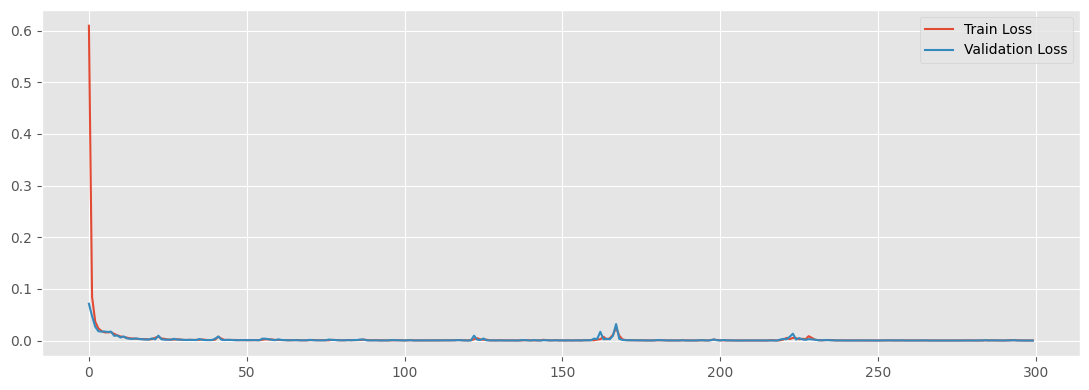

In [151]:
plot_model_history(df_history)

### Validation

In [173]:
# Obtain Predictions
def consume_model(model,features,scaler):
    predictions = model.predict(features)
    predictions = scaler.inverse_transform(predictions) #convert prediction first by inverting the Robust scaler transformation and then the e_logarithmic one.
    predictions = np.exp(predictions)

    predictions = np.concatenate([a[:1] for a in predictions])
    
    return predictions

def calculate_analytical_parameters(actual,predicted):
    x = actual[:len(predicted)]
    y = predicted
    analytical_parameters = {}

    analytical_params = linregress(x, y)

    slope = analytical_params.slope
    intercept = analytical_params.intercept
    rvalue = analytical_params.rvalue
    y_trend_line = slope*x + intercept #this is computed just for the avg_tld
    avg_trend_line_distance = np.mean(np.abs(y_trend_line - y)/y_trend_line)

    analytical_parameters['slope'] = slope
    analytical_parameters['intercept'] = intercept
    analytical_parameters['rvalue'] = rvalue
    analytical_parameters['dispersion'] = avg_trend_line_distance
    analytical_parameters['mse'] = mean_squared_error(x,y) 
    analytical_parameters['rmse'] = np.sqrt(mean_squared_error(x,y))
    analytical_parameters['mape'] = mean_absolute_percentage_error(x,y)
    
    return analytical_parameters

train_predictions = consume_model(prediction_model,X_train,robust_scaler_targets)
pred_predictions = consume_model(prediction_model,X_predict,robust_scaler_targets)

#validation_predictions = consume_model(prediction_model,X_validation,robust_scaler_targets)
#test_predictions = consume_model(prediction_model,X_test,robust_scaler_targets)

train_analytical_parameters = calculate_analytical_parameters(train_actual_target_list,train_predictions)
prediction_analytical_parameters = calculate_analytical_parameters(prediction_actual_target_list,pred_predictions)
#validation_analytical_parameters = calculate_analytical_parameters(validation_actual_target_list,validation_predictions)
#test_analytical_parameters = calculate_analytical_parameters(test_actual_target_list,test_predictions)


2024-02-01 13:21:54.040197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-01 13:21:54.042529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-01 13:21:54.044065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 0s 3ms/step


In [174]:
print(f'Train accuracy : \n', train_analytical_parameters)
print(f'Prediction accuracy: \n', prediction_analytical_parameters)
#print(f'Validation accuracy : \n', validation_analytical_parameters)
#print(f'Test accuracy : \n', test_analytical_parameters)

Train accuracy : 
 {'slope': 0.5316934562086, 'intercept': 93.44350331739992, 'rvalue': 0.9251566273590005, 'dispersion': 0.08020605984346593, 'mse': 2010.2819833229764, 'rmse': 44.83616824978442, 'mape': 0.2737007915658087}
Prediction accuracy: 
 {'slope': 0.535717986412478, 'intercept': 92.96386430577698, 'rvalue': 0.9248747198171328, 'dispersion': 0.07864470577584061, 'mse': 1881.3417522465288, 'rmse': 43.37443662166148, 'mape': 0.2629252708114878}


### TPG

{'Comparision': {'trend_slope': 0.5296002273629911,
  'trend_intercept': 94.64782760193064,
  'trend_r2': 0.8496522329756159,
  'dispersion': 0.08084079146915858},
 'Ratio': {'trend_slope': -0.0044842409126371625,
  'trend_intercept': 2.0802455378413365,
  'trend_r2': 0.7443574188566973,
  'dispersion': 0.15718101525658607},
 'Scatter': {'trend_slope': 0.5296002273629911,
  'trend_intercept': 94.64782760193064,
  'trend_r2': 0.8496522329756159,
  'dispersion': 0.08084079146915858}}

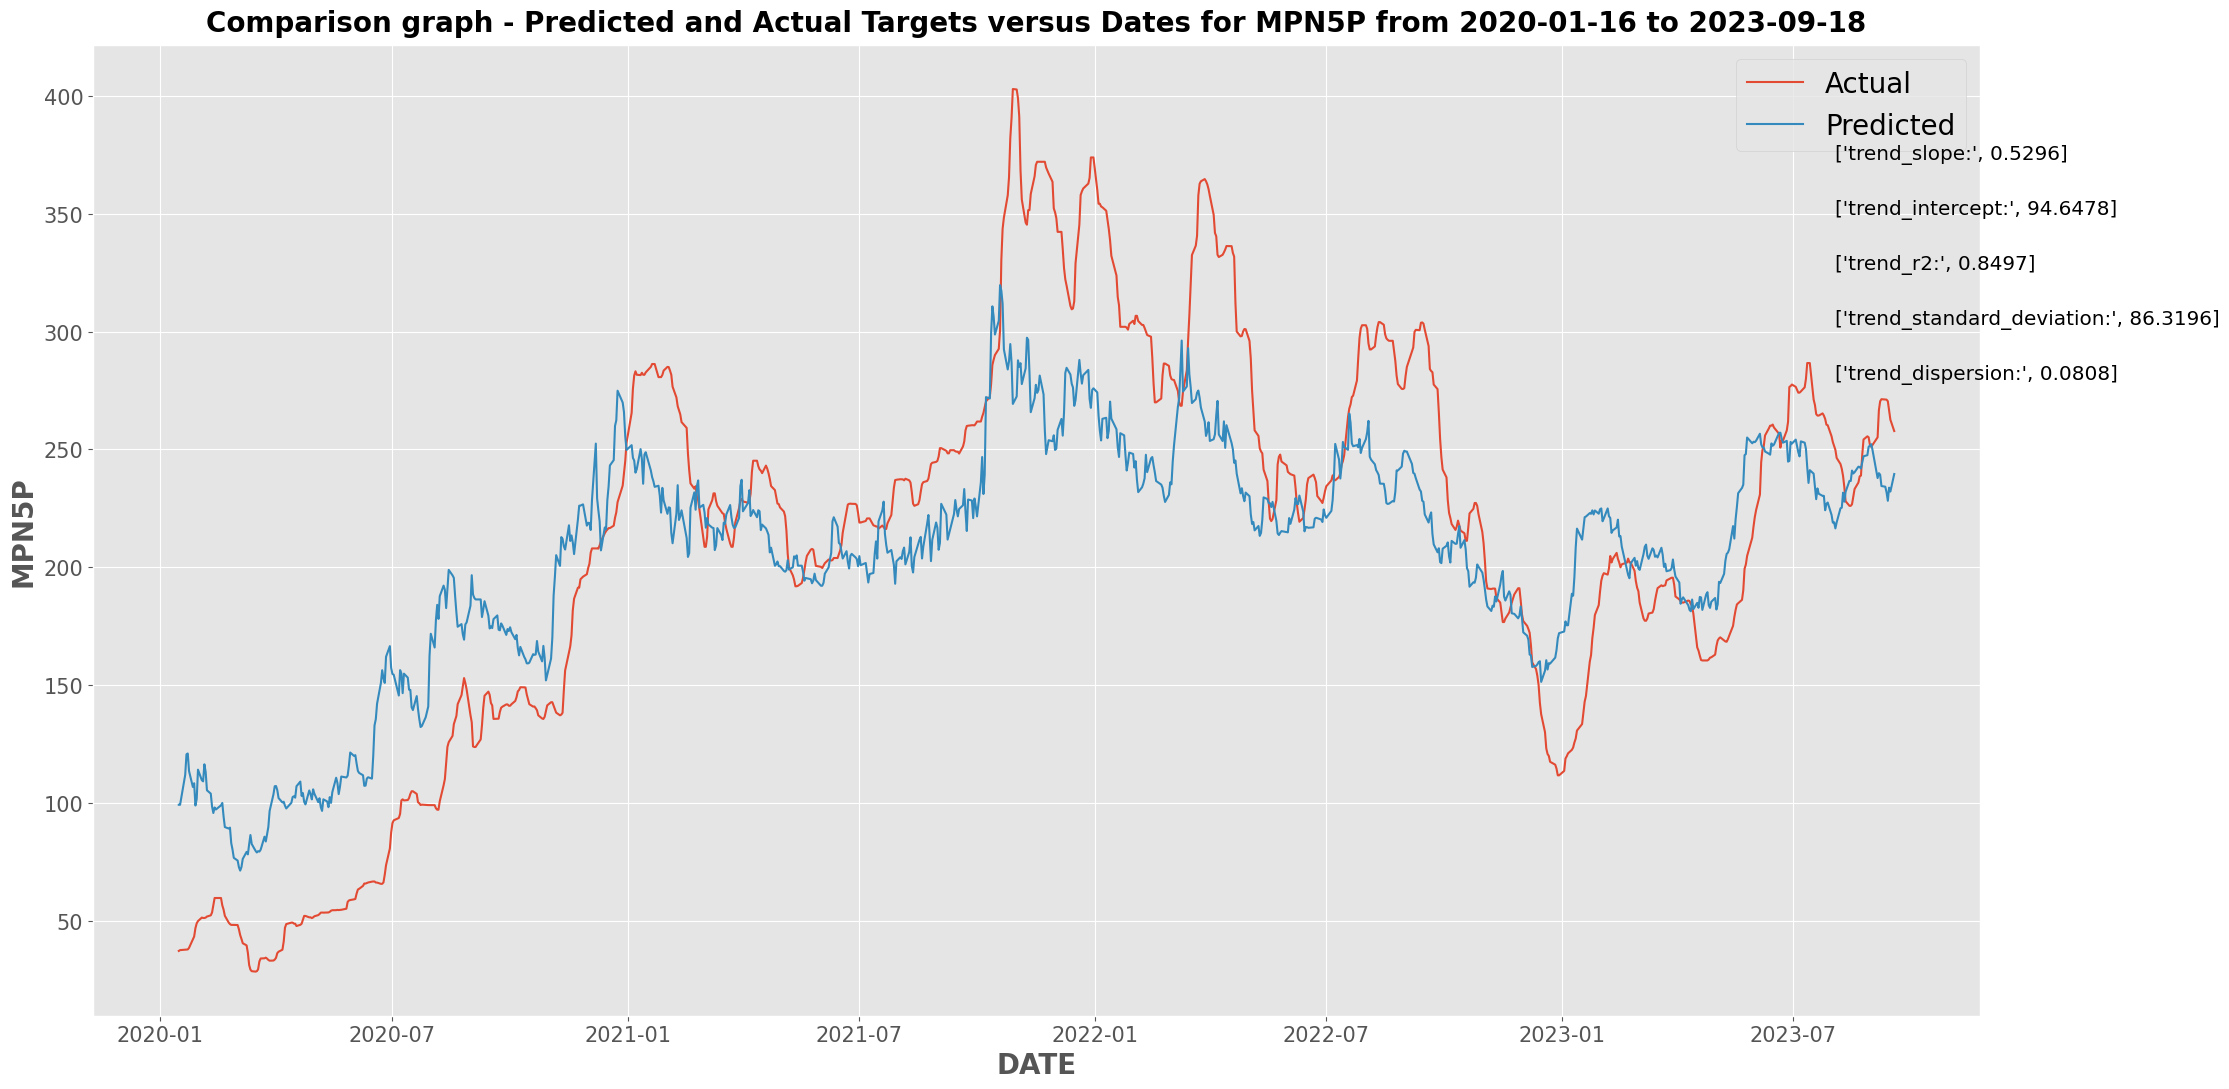

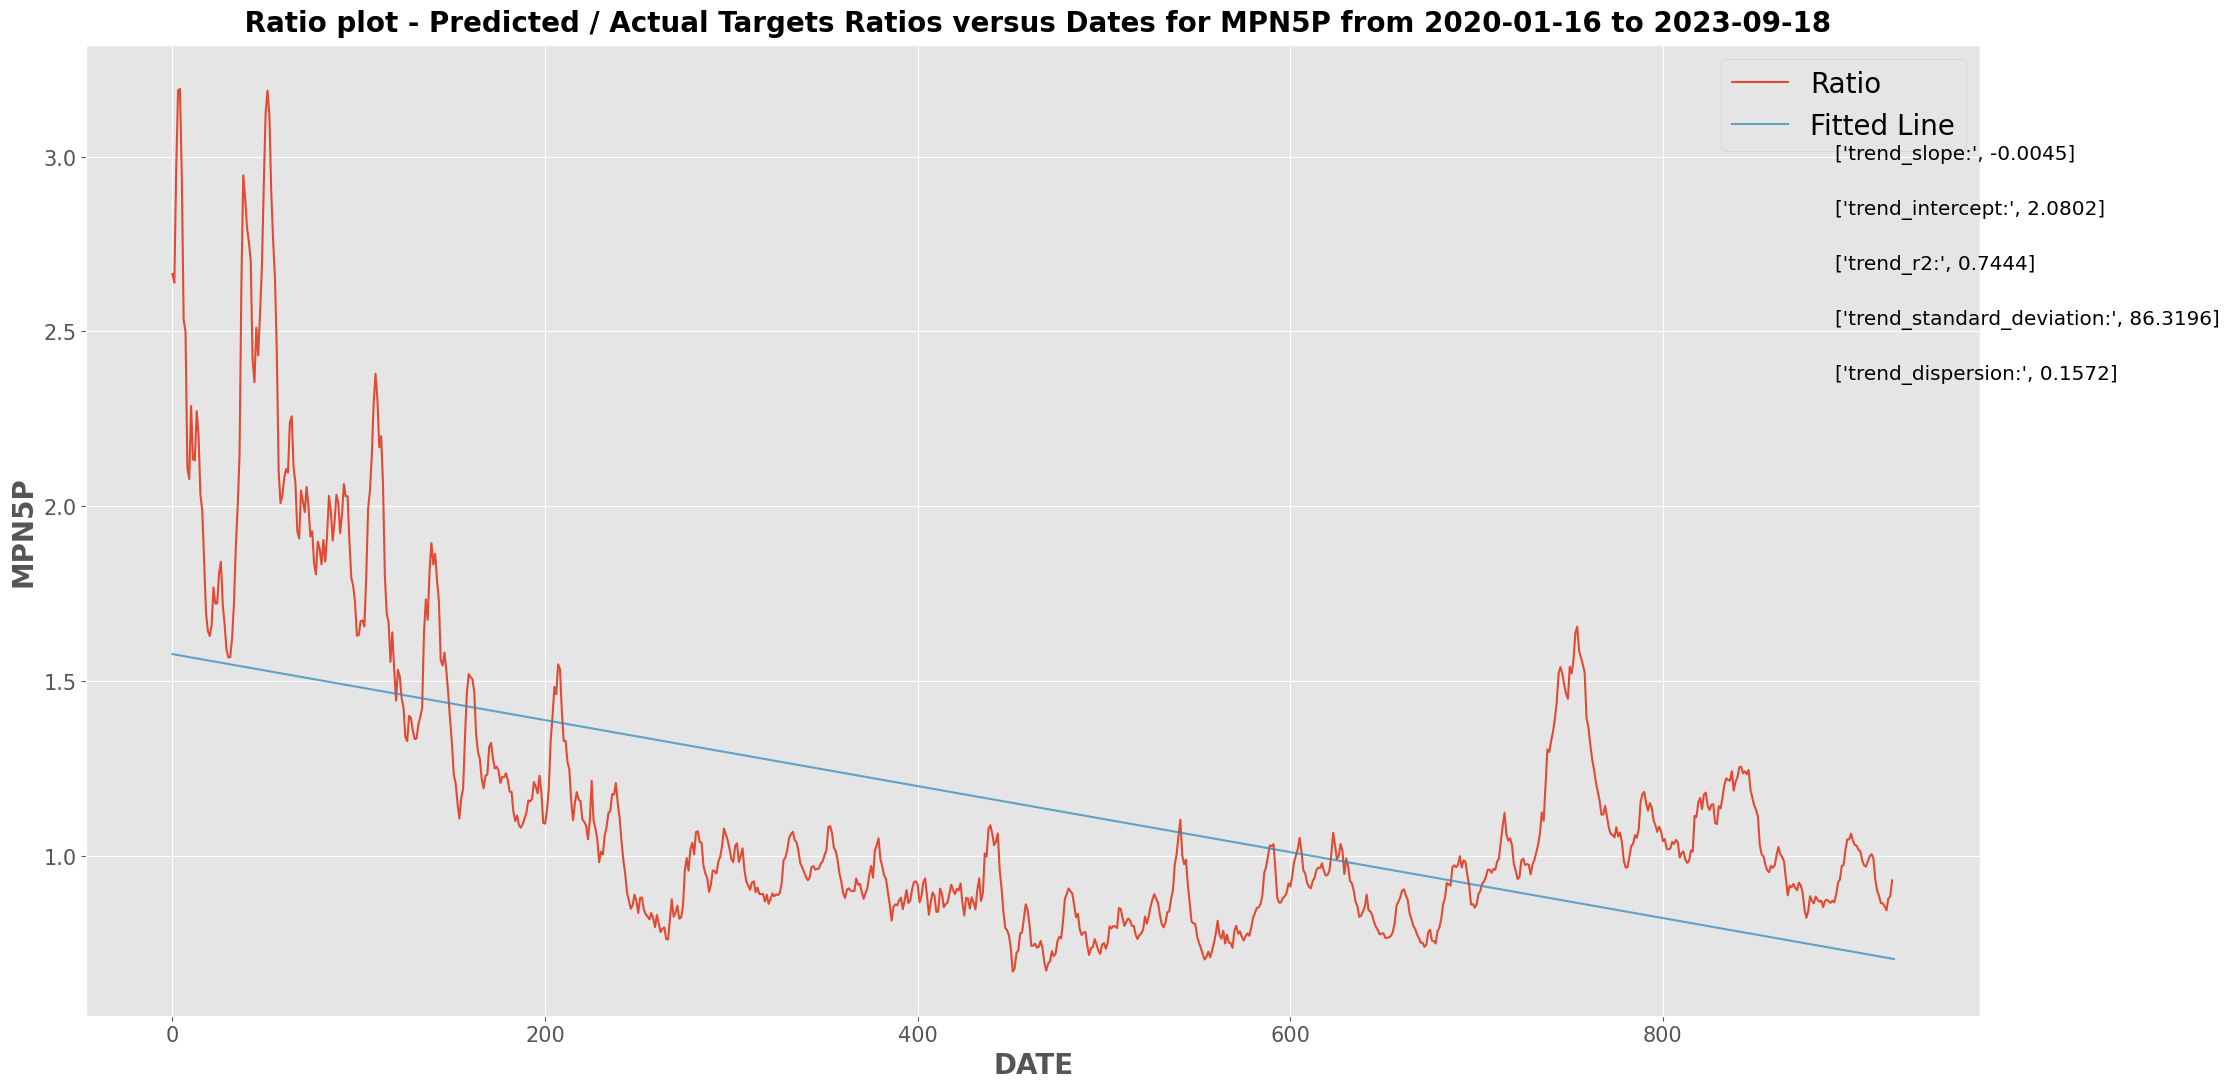

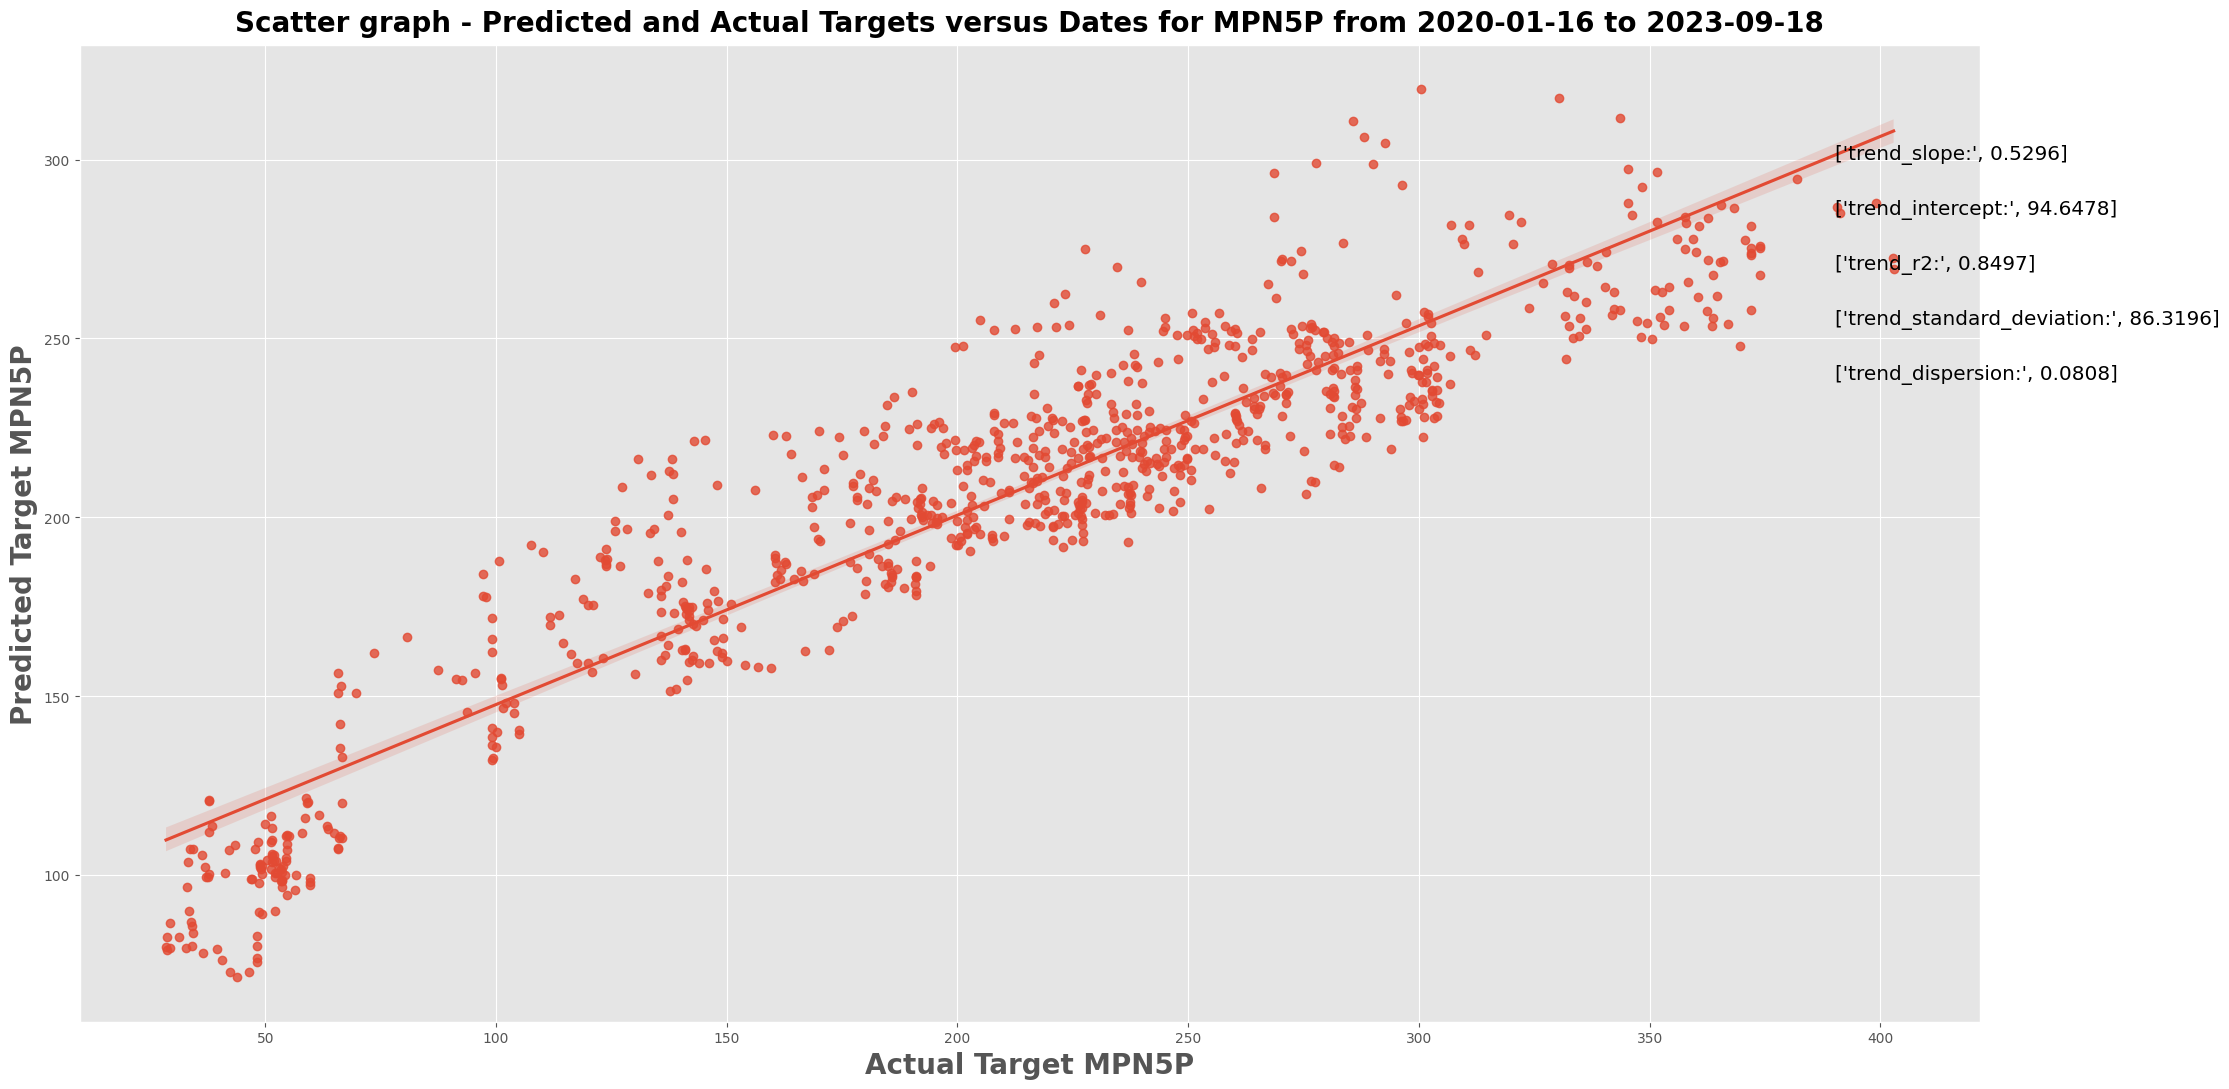

In [128]:
# Train
train_predictions_arr = train_predictions.tolist()
train_actual_target_arr = train_actual_target_list[:len(train_predictions)]

plot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_train')
dates = [str(pd.to_datetime(date).date()) for date in train_dates_np_arr]
dates = dates[:len(train_predictions)]

generate_plot(predicted_targets=train_predictions_arr,
              actual_targets=train_actual_target_arr,
              plot_path=plot_path,
              dates = dates,
              target='MPN5P')


{'Comparision': {'trend_slope': 0.5336473269027009,
  'trend_intercept': 94.16771437951888,
  'trend_r2': 0.8484041799900656,
  'dispersion': 0.07953525462162024},
 'Ratio': {'trend_slope': -0.0045757653948328625,
  'trend_intercept': 2.097633967525432,
  'trend_r2': 0.7484709844037276,
  'dispersion': 0.15531337841006934},
 'Scatter': {'trend_slope': 0.5336473269027009,
  'trend_intercept': 94.16771437951888,
  'trend_r2': 0.8484041799900656,
  'dispersion': 0.07953525462162024}}

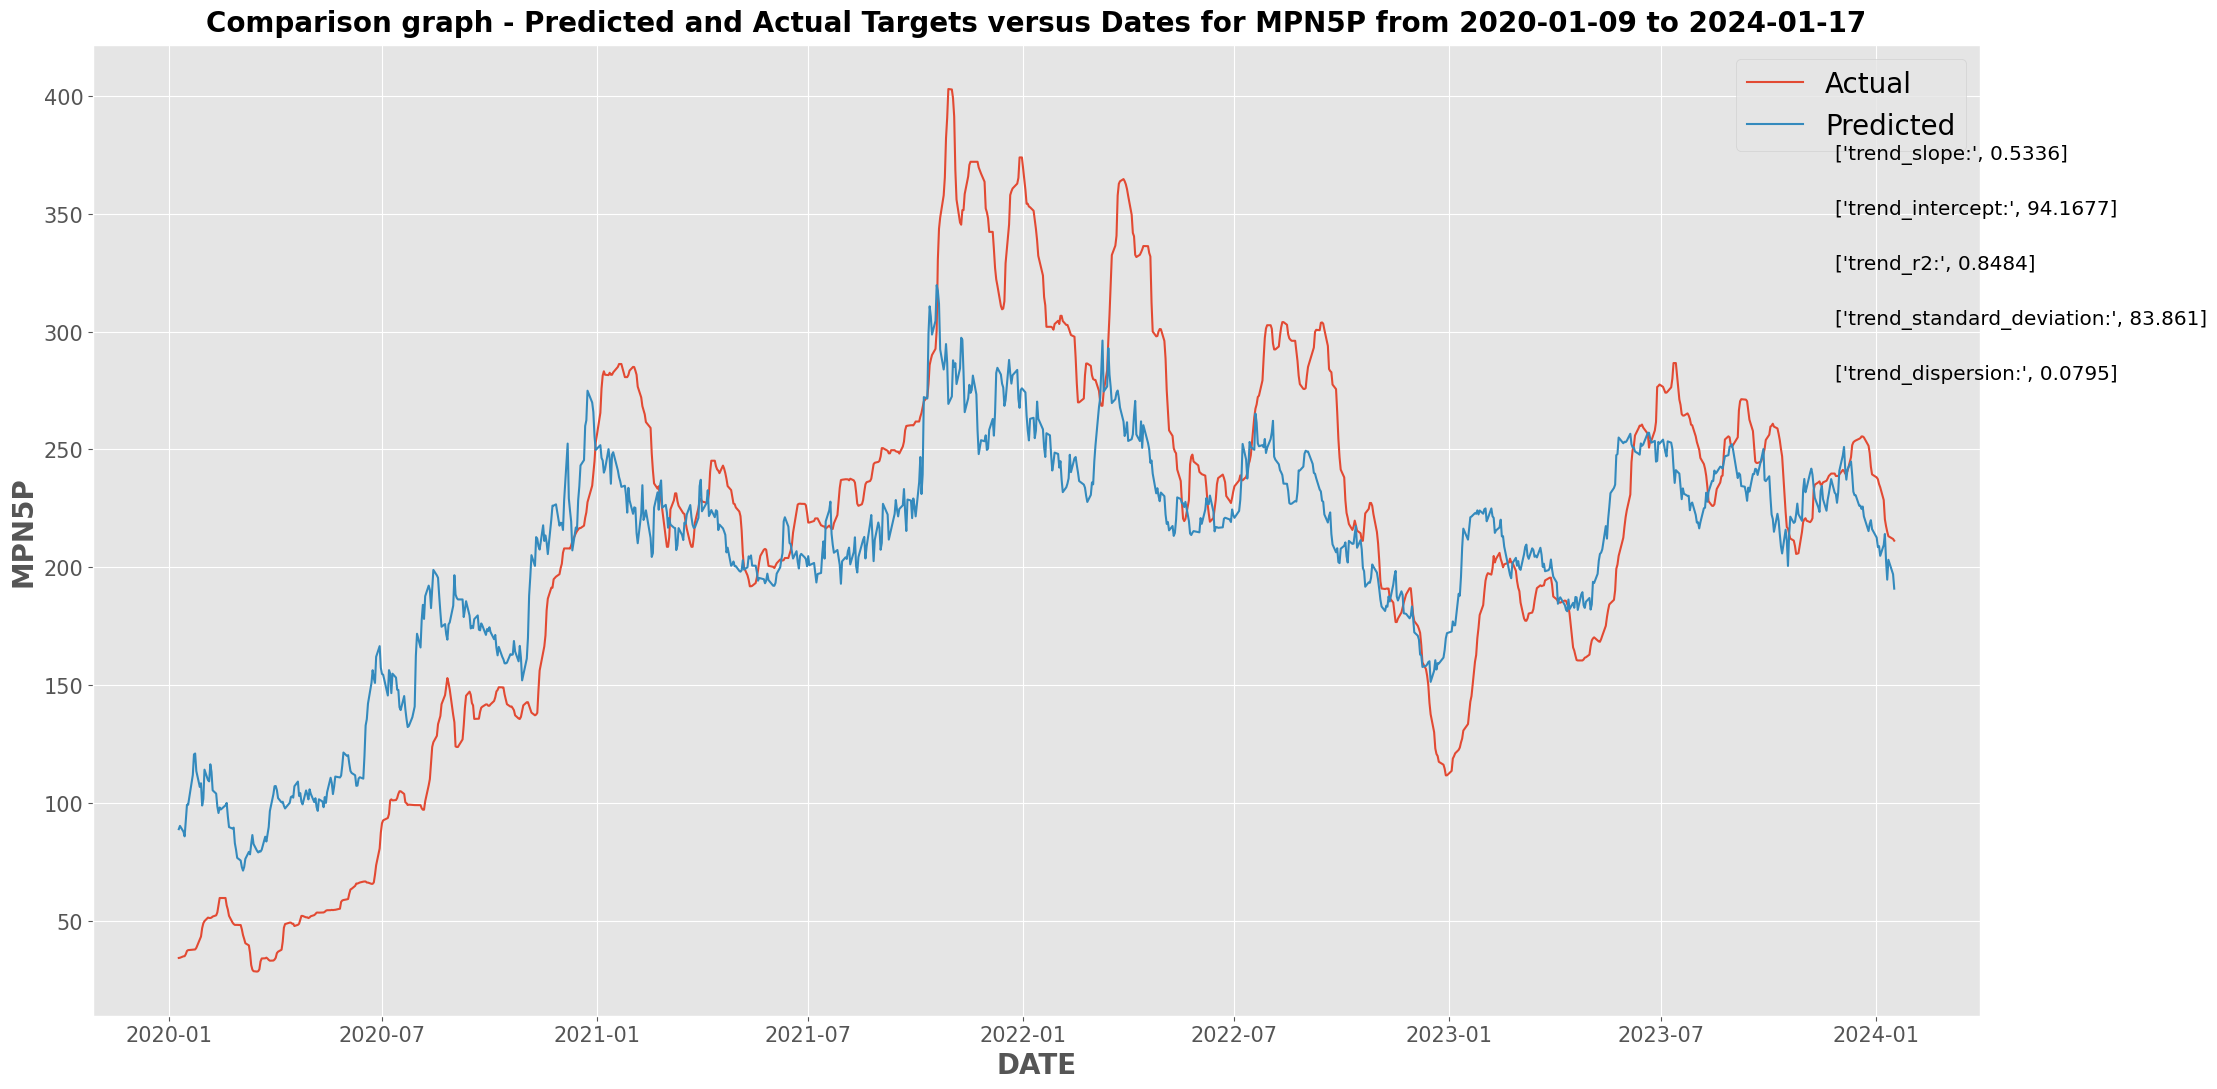

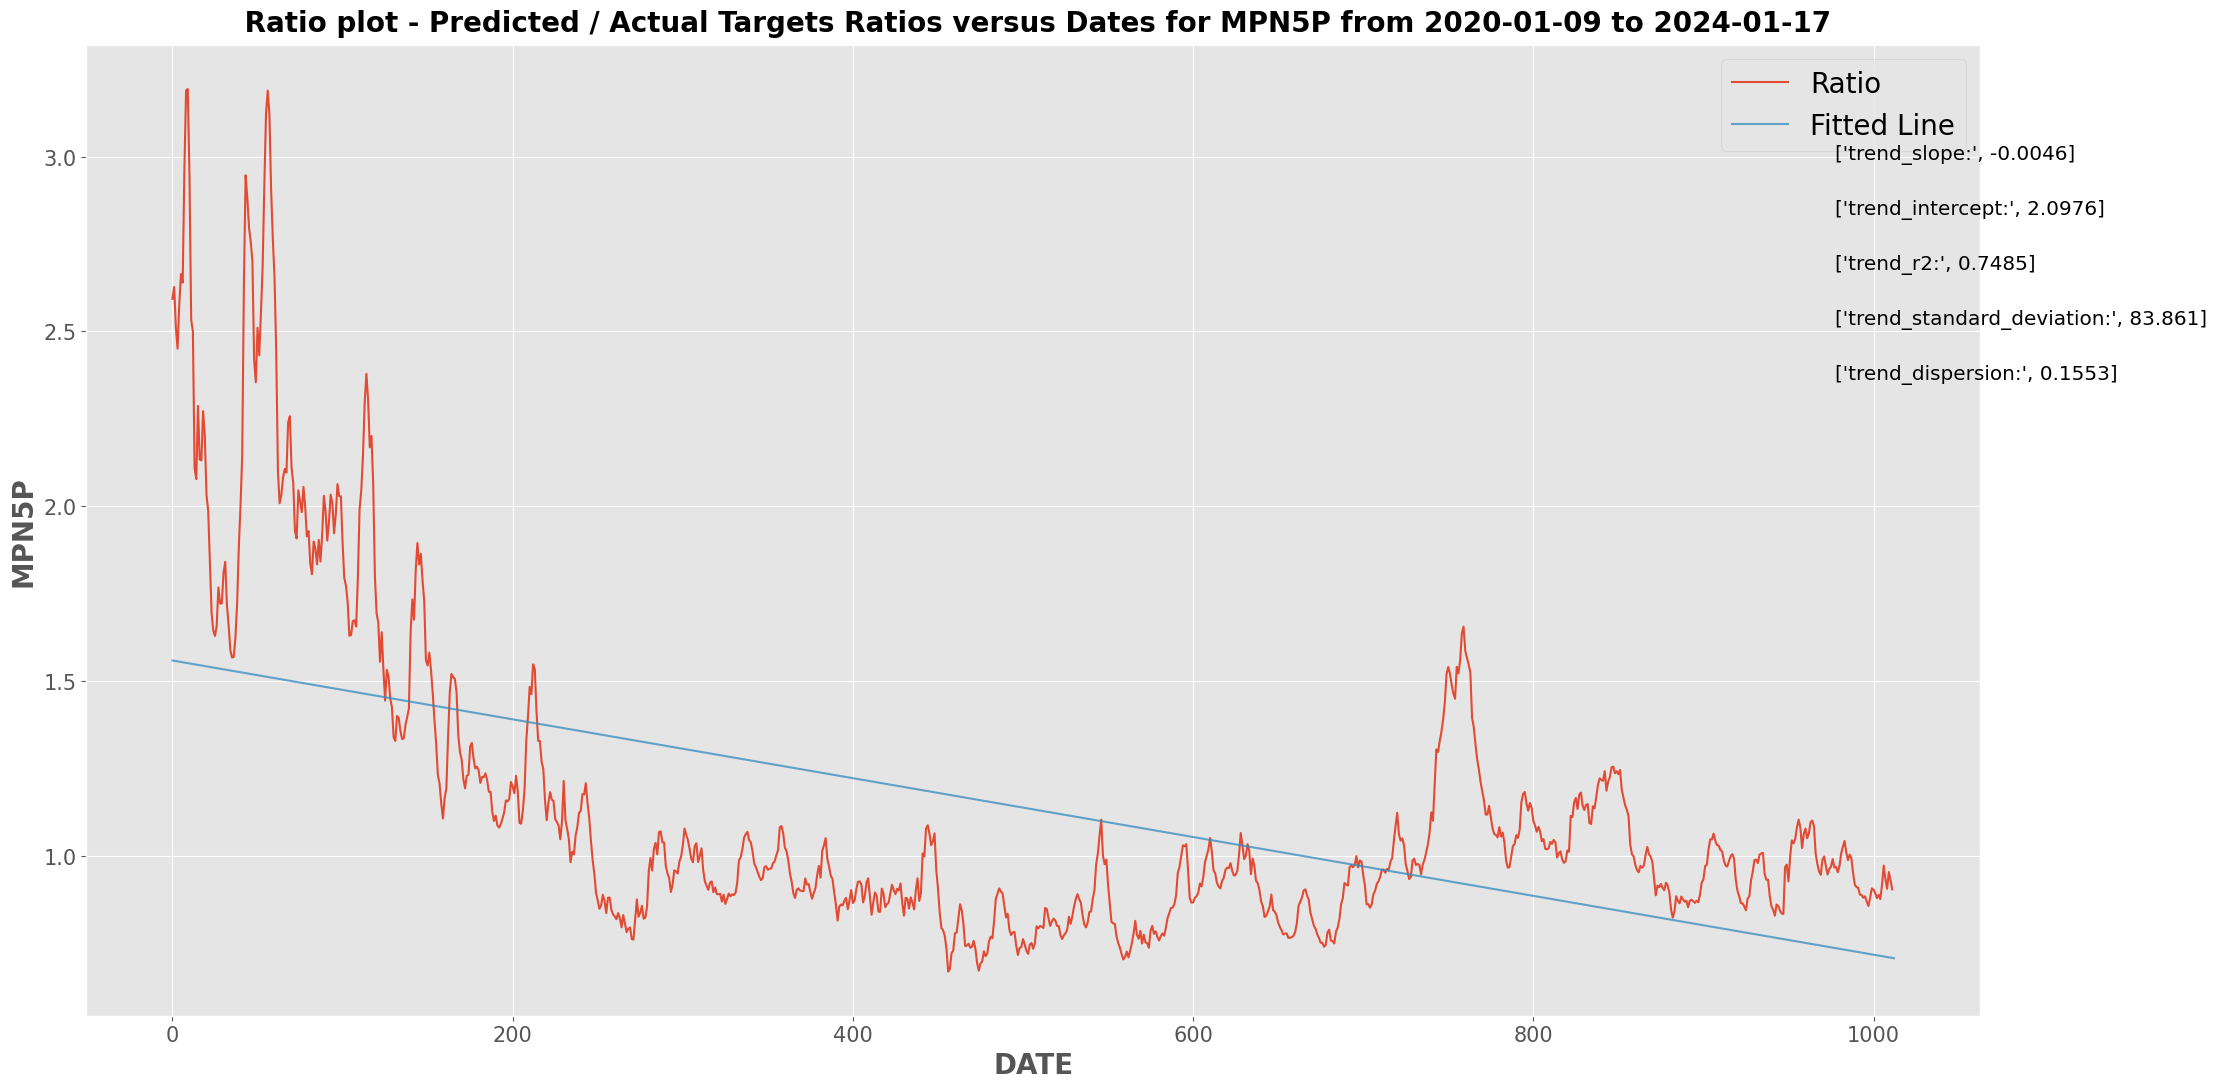

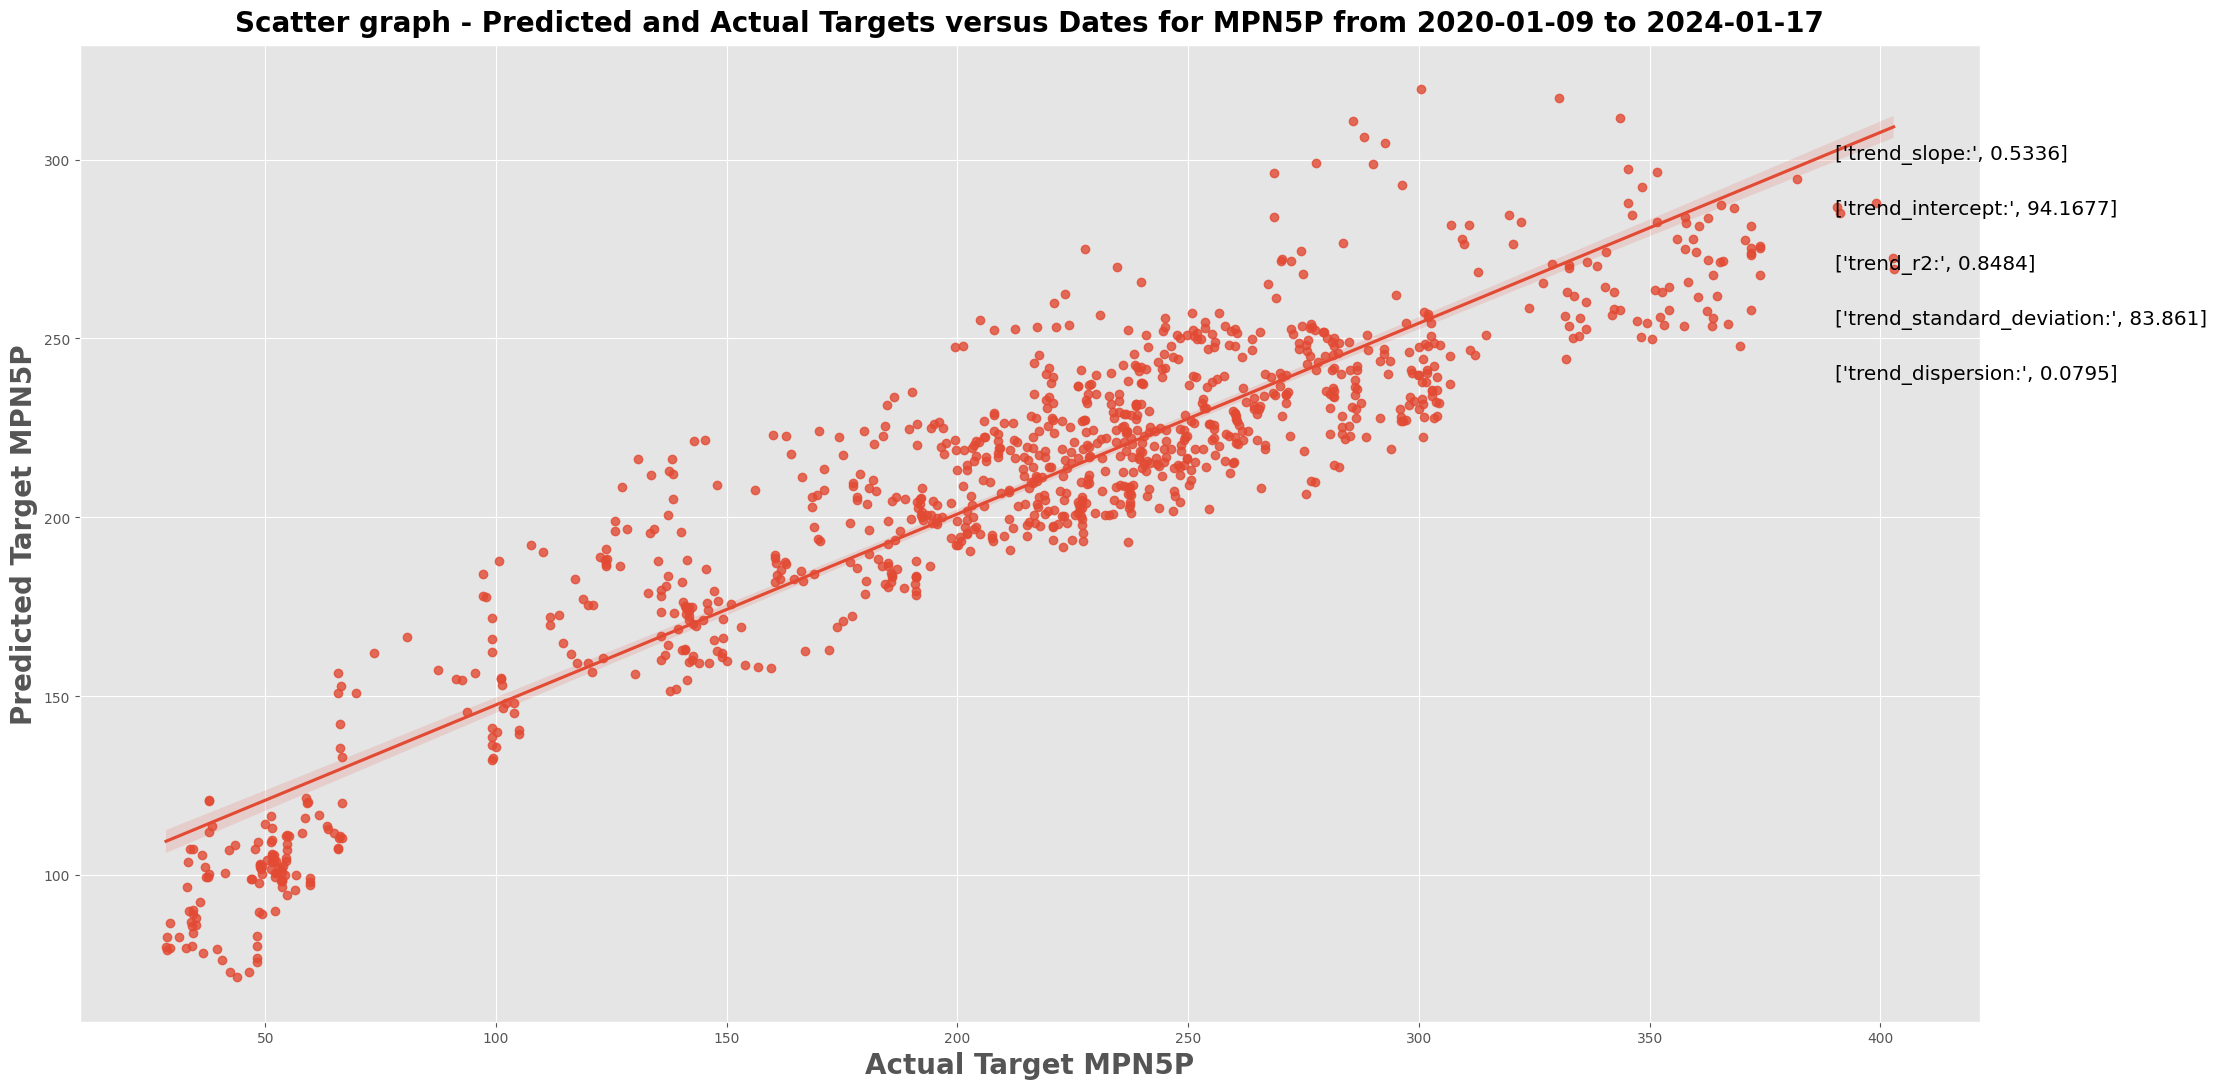

In [129]:
# Prediction set
pred_predictions_arr = pred_predictions.tolist()
pred_actual_target_arr = prediction_actual_target_list[:len(pred_predictions)]

plot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_train')
dates = [str(pd.to_datetime(date).date()) for date in prediction_dates_arr]
dates = dates[:len(pred_predictions)]

generate_plot(predicted_targets=pred_predictions_arr,
              actual_targets=pred_actual_target_arr,
              plot_path=plot_path,
              dates = dates,
              target='MPN5P')


In [130]:
# Val Set
'''
val_predictions_arr = validation_predictions.tolist()
val_actual_target_arr = validation_actual_target_list[:len(validation_predictions)]

plot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_validation')
dates = [str(pd.to_datetime(date).date()) for date in validation_dates_np_arr]
dates = dates[:len(validation_predictions)]

generate_plot(predicted_targets=val_predictions_arr,
              actual_targets=val_actual_target_arr,
              plot_path=plot_path,
              dates = dates,
              target='MPN5P')

'''

"\nval_predictions_arr = validation_predictions.tolist()\nval_actual_target_arr = validation_actual_target_list[:len(validation_predictions)]\n\nplot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_validation')\ndates = [str(pd.to_datetime(date).date()) for date in validation_dates_np_arr]\ndates = dates[:len(validation_predictions)]\n\ngenerate_plot(predicted_targets=val_predictions_arr,\n              actual_targets=val_actual_target_arr,\n              plot_path=plot_path,\n              dates = dates,\n              target='MPN5P')\n\n"

## Corrections

### Vertical Corrections

In [131]:
dncp_train = dohlcav_mpnxp_data[train_mask]['DNCP_day_number_current_period'].replace(',','', regex=True)[timesteps-1+main_target_code_integer:]
dncp_train = dncp_train.astype(int).to_numpy()
span_dncp_train = dncp_train[-1] - dncp_train[0] +1
positions_day_number_train= dncp_train-dncp_train[0]+1

print('positions_day_number_train', len(positions_day_number_train))

positions_day_number_train 924


In [132]:
#this is calculate the period day number to be used in the prediction section
dncp = dohlcav_mpnxp_data['DNCP_day_number_current_period'].replace(',','', regex=True)[timesteps-1+main_target_code_integer:]
dncp = dncp.astype(int).to_numpy()
span_dncp=dncp[-1] - dncp[0] + 1
positions_day_number = dncp-dncp[0]+1

print('positions_day_number ', len(positions_day_number))

positions_day_number  1012


In [133]:
actual = actuals_targets[0][:len(train_predictions)]

train_raw_targets_ratio = train_predictions/actual
train_raw_trend_slope, train_raw_trend_intercept, _, train_raw_trend_dispersion= sir_parameters(positions_day_number_train,train_raw_targets_ratio)

vertical_padding_correction_factor = 1/train_raw_trend_intercept
corrected_train_raw_targets_ratios = train_raw_targets_ratio * vertical_padding_correction_factor

train_vertical_corrected_targets = corrected_train_raw_targets_ratios * actual#this is the formula for vertical padding

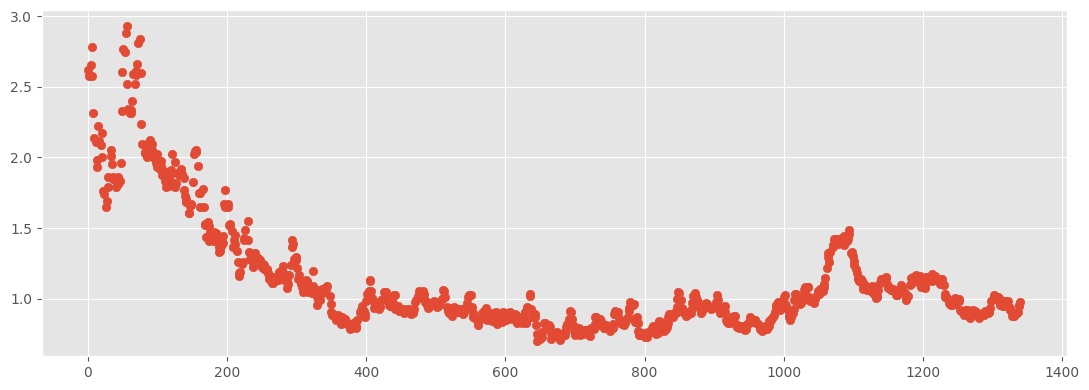

In [134]:
plt.scatter(positions_day_number_train,train_raw_targets_ratio)

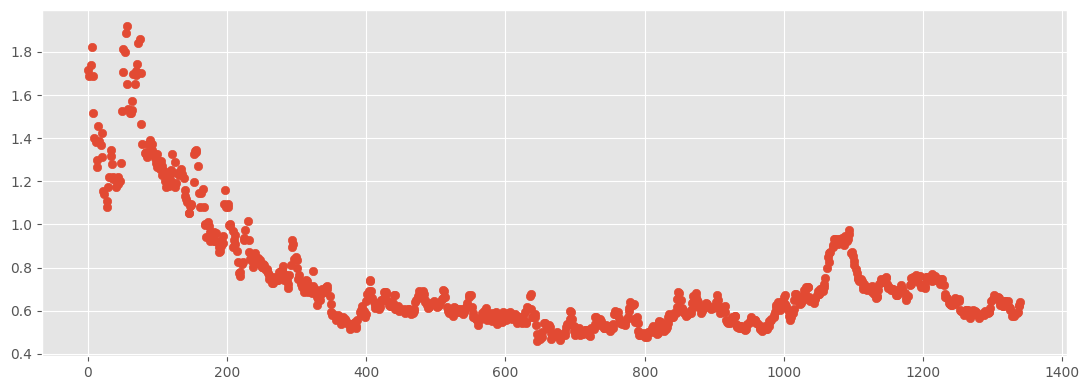

In [135]:
plt.scatter(positions_day_number_train,corrected_train_raw_targets_ratios)

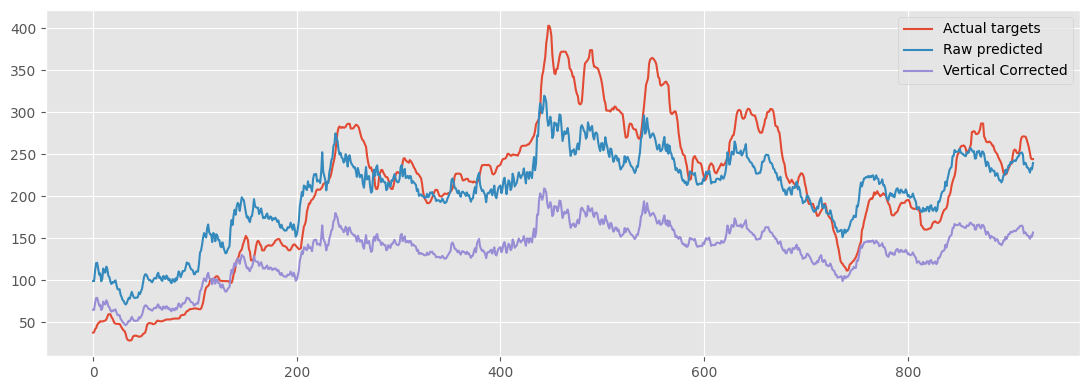

In [136]:
ax = plt.plot(actual,label='Actual targets')
ax = plt.plot(train_predictions,label='Raw predicted')
plt.plot(train_vertical_corrected_targets,label='Vertical Corrected')

plt.legend()

### Swing Padding Correction

In [137]:
swing_padding_correction_factors = []
train_vertical_targets_ratios = train_vertical_corrected_targets / actual
train_vertical_trend_slope, train_vertical_trend_intercept, _, train_vertical_trend_dispersion= sir_parameters(positions_day_number_train, train_vertical_targets_ratios)

for i in positions_day_number_train:
    swing_padding_correction_factor = 1 / (1 + i * train_vertical_trend_slope)
    swing_padding_correction_factors.append(swing_padding_correction_factor)

In [138]:
swing_targets_ratios = train_raw_targets_ratio* vertical_padding_correction_factor*swing_padding_correction_factors
swing_predicted_targets = swing_targets_ratios * actual

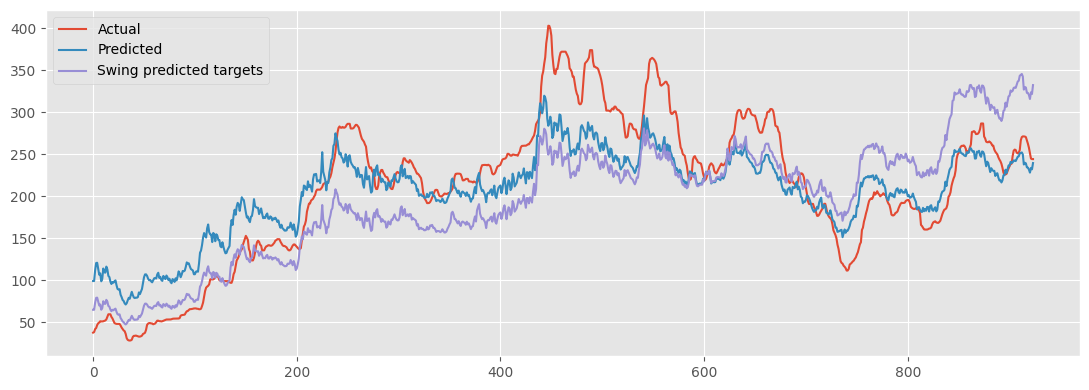

In [139]:
ax = plt.plot(actual,label='Actual')
ax = plt.plot(train_predictions,label='Predicted')
plt.plot(swing_predicted_targets,label='Swing predicted targets')

plt.legend()

### Correction LSTM

In [140]:
correction_lr=0.0005
correction_batch = 64
correction_epochs = 100

CORR_MODEL_NAME = f'Correction_LSTM_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}.h5'
CORR_HIST_NAME = f'Correction_LSTM_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}_model_history.csv'

print(MODEL_PATH / CORR_MODEL_NAME)
print(MODEL_PATH / CORR_HIST_NAME)

train_correction = False
save_correction_model = True

/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/Correction_LSTM_T10_E300_B64_2020-01-01.h5
/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/Correction_LSTM_T10_E300_B64_2020-01-01_model_history.csv


#### Correction Model

In [141]:
def create_correction_model(correction_lr,correction_input_shape):
    tf.keras.backend.clear_session()
    correction_model = Sequential()
    correction_model.add(LSTM(2**twoexp_nodes_number_layer_1,input_shape=correction_input_shape,return_sequences=True))
    correction_model.add(LSTM(2**twoexp_nodes_number_layer_2, return_sequences=True))
    correction_model.add(LSTM(2**twoexp_nodes_number_layer_3))
    correction_model.add(Dense(2**twoexp_nodes_number_layer_4))
    correction_model.add(Dense(2**twoexp_nodes_number_layer_5))

    correction_model.compile(optimizer = Adam(learning_rate=correction_lr), loss = custom_loss_function(attenuated_padding_value))

    return correction_model

In [142]:
volume = df_actual['VTCP'].reset_index().drop('DATE',axis=1)
correction_lstm_table,lstm_robust_feat,lstm_robust_target,actual_correct=preprare_correction_lstm_table_train(positions_day_number_train,swing_predicted_targets,volume,actual)
correction_train_data=correction_lstm_table
X_correction_train, y_correction_train =correction_data_sequences(correction_train_data, int(model_case_version_time_steps))

correction_input_shape=((X_correction_train).shape[1],(X_correction_train).shape[2])
print('Correction input shape: ', correction_input_shape)

     period_day_number  raw_predicted_targets  new_feature       volume  \
0                    8              74.644023     0.582313          NaN   
1                    9              70.247435     0.592350          NaN   
2                   12              71.376235     0.573789          NaN   
3                   13              65.182042     0.547284          NaN   
4                   14              67.048064     0.590290          NaN   
..                 ...                    ...          ...          ...   
914               1335             320.452028     0.829504   99130350.0   
915               1336             315.733979     0.821505  135782300.0   
916               1337             323.722524     0.820948  110419696.0   
917               1338             321.682525     0.824976  107029784.0   
918               1339             332.278356     0.813144  132401856.0   

     actual_raw_predited_ratio  
0                     0.656181  
1                     0.710783  


In [143]:
if train_correction:
    correction_model = create_correction_model(
        correction_lr = correction_lr,
        correction_input_shape=correction_input_shape
    )

    correction_model_history = correction_model.fit(
        X_correction_train,
        y_correction_train,
        batch_size=correction_batch,
        epochs=correction_epochs,
    )

    df_history = pd.DataFrame(correction_model_history.history, columns={'loss': 'train_loss', 'val_loss': 'val_loss'})
    if save_correction_model:
        correction_model.save(MODEL_PATH / CORR_MODEL_NAME)
        df_history.to_csv(MODEL_PATH / CORR_HIST_NAME,index=False)
else:
    tf.keras.backend.clear_session()
    correction_model = load_model(MODEL_PATH / CORR_MODEL_NAME,compile=False)
    print(correction_model.summary())
    #df_history = pd.read_csv(MODEL_PATH / HIST_NAME)

OSError: No file or directory found at /home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/Correction_LSTM_T10_E300_B64_2020-01-01.h5

### Correction Model Predictions

In [ ]:
LSTM_corrections=correction_model.predict(X_correction_train)
LSTM_corrections=lstm_robust_target.inverse_transform(LSTM_corrections.reshape(-1,1))
LSTM_corrections=LSTM_corrections.reshape(1,-1)[0]

29/29 [==============================] - 2s 59ms/step


In [ ]:
compare_corrections=lstm_robust_target.inverse_transform(correction_lstm_table[:,2][int(model_case_version_time_steps)-1 + int(model_case_version_main_target_code):].reshape(1,-1))
actual_corrections=actual_correct

array([0.78343566, 0.87200407, 0.88187799, 0.90714683, 0.87062924,
       0.83400524, 0.78059108, 0.75449312, 0.72148792, 0.75248393,
       0.78784876, 0.79383992, 0.80857431, 0.80501779, 0.8043216 ,
       0.80198504, 0.78021   , 0.76695258, 0.70086313, 0.60329479,
       0.54686442, 0.51683581, 0.5134523 , 0.50412513, 0.50859038,
       0.56905943, 0.613613  , 0.62786347, 0.62051362, 0.61561727,
       0.60412728, 0.58099496, 0.58661559, 0.5793008 , 0.58002383,
       0.59151569, 0.55197428, 0.52429044, 0.56433945, 0.66480285,
       0.69528731, 0.72310659, 0.71866327, 0.72177002, 0.73119787,
       0.70920666, 0.6919779 , 0.68856536, 0.72708178, 0.71216169,
       0.708667  , 0.74603814, 0.7420781 , 0.74585093, 0.75671046,
       0.74034927, 0.73662891, 0.75165717, 0.75096078, 0.76990315,
       0.78854252, 0.78109018, 0.78186239, 0.79458706, 0.78037304,
       0.77876285, 0.79684602, 0.77869543, 0.79397415, 0.78760024,
       0.73464278, 0.74366216, 0.8140458 , 0.81836492, 0.80935

In [ ]:
compare_corrections = lstm_robust_target.inverse_transform(
    correction_lstm_table[:,2][
        int(model_case_version_time_steps)-1 + int(model_case_version_main_target_code):
        ].reshape(1,-1))

actual_corrections=actual_correct

In [ ]:
corrected_predicted_targets = np.multiply(
    swing_predicted_targets[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):], 
    LSTM_corrections
)

In [ ]:
correction_dispersion = sir_parameters(actual_corrections[int(model_case_version_main_target_code):],LSTM_corrections)

In [ ]:
period_day_number_temp=positions_day_number_train[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):]
period_day_number=period_day_number_temp-period_day_number_temp[0]+1
actual_moving_average=actual[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):]

### Last Padding Correction

In [ ]:
last_padding_correction_factors = []
last_padding_correction_factors.append(1)
last_padding_correction_factors.append(1)
last_padding_correction_factors.append(1)
last_padding_correction_factors.append(1)

for i in range(4,len(period_day_number)):    
    last_padding_correction_factors.append(((actual_moving_average[i-1]+actual_moving_average[i-2]+actual_moving_average[i-3]+actual_moving_average[i-4])/4)/((corrected_predicted_targets[i-1]+corrected_predicted_targets[i-2]+corrected_predicted_targets[i-3]+corrected_predicted_targets[i-4])/4))

initial_last_ratio=corrected_predicted_targets/actual_moving_average
last_targets_ratios = initial_last_ratio * last_padding_correction_factors
last_slope,last_start_intercept,_,last_dispersion=sir_parameters(period_day_number,last_targets_ratios)
last_predicted_targets = last_targets_ratios*actual_moving_average

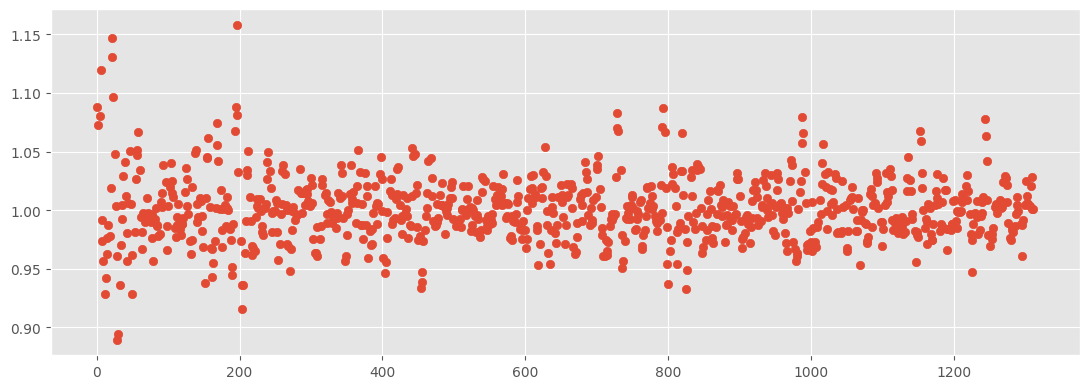

In [ ]:
plt.scatter(period_day_number,last_targets_ratios)

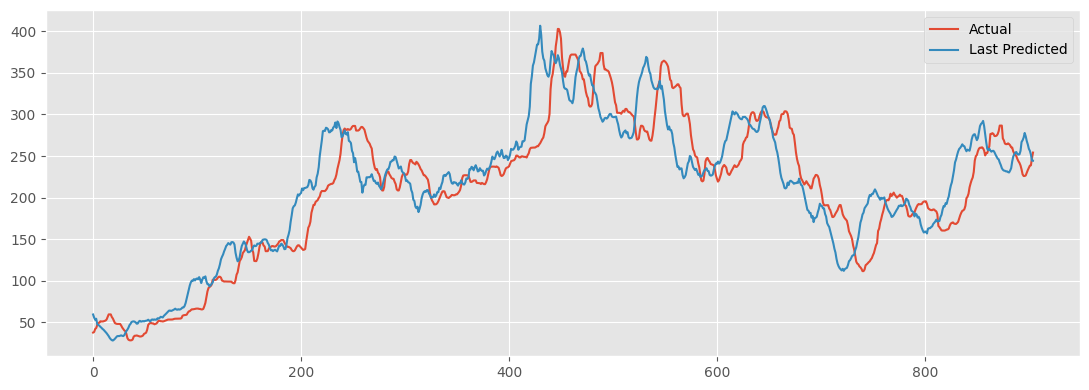

In [ ]:
plt.plot(actual[:len(last_predicted_targets)],label='Actual')
plt.plot(last_predicted_targets,label='Last Predicted')

plt.legend()